In [1]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
# import seaborn
import pickle
import pylab as PL

In [2]:
most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/retrained_quick_pvalues.py','rb'))

In [3]:
filt_mean_features = {}
with h5py.File(GTEx_directory + '/data/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    filt_expression = expression[:, most_expressed_transcript_idx]
    for s in ['128','256','512','1024','2048','4096']:
        size_mean_features = f['lung'][s]['mean'].value
        filt_mean_features[s] = size_mean_features[:,most_varying_feature_idx]
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

In [4]:
filt_mean_features['128'].shape

(274, 100)

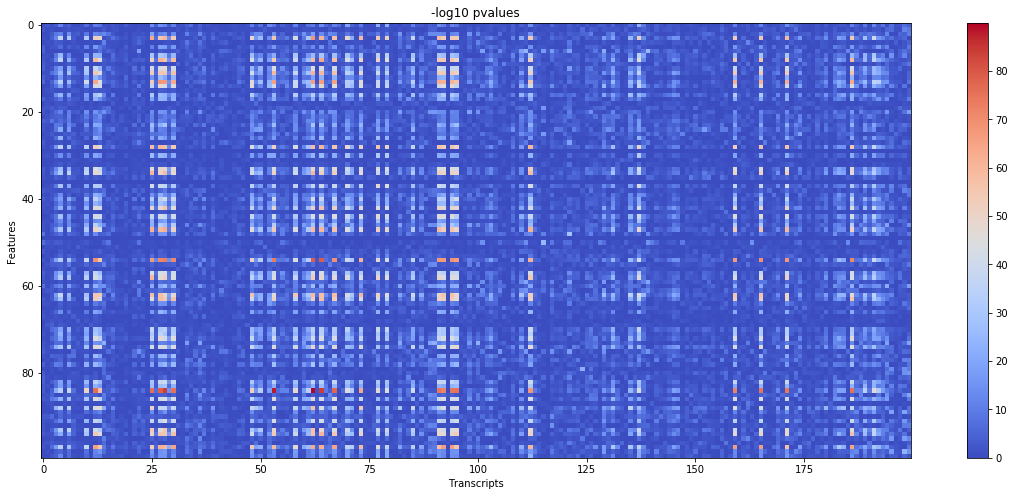

In [30]:
PL.figure(None,[20,8])
PL.imshow(-np.log(results['mean_256_pvalues']), interpolation="none", cmap=PL.get_cmap("coolwarm"))
PL.title("-log10 pvalues")
PL.xlabel("Transcripts"); PL.ylabel("Features")
PL.colorbar()


In [60]:
from pyensembl import EnsemblRelease
data = EnsemblRelease(77)
data.gene_by_id('ENSG00000237973').gene_name

'MIR6723'

In [57]:
expression_IDs[most_expressed_transcript_idx][col]

b'ENSG00000237973.1'

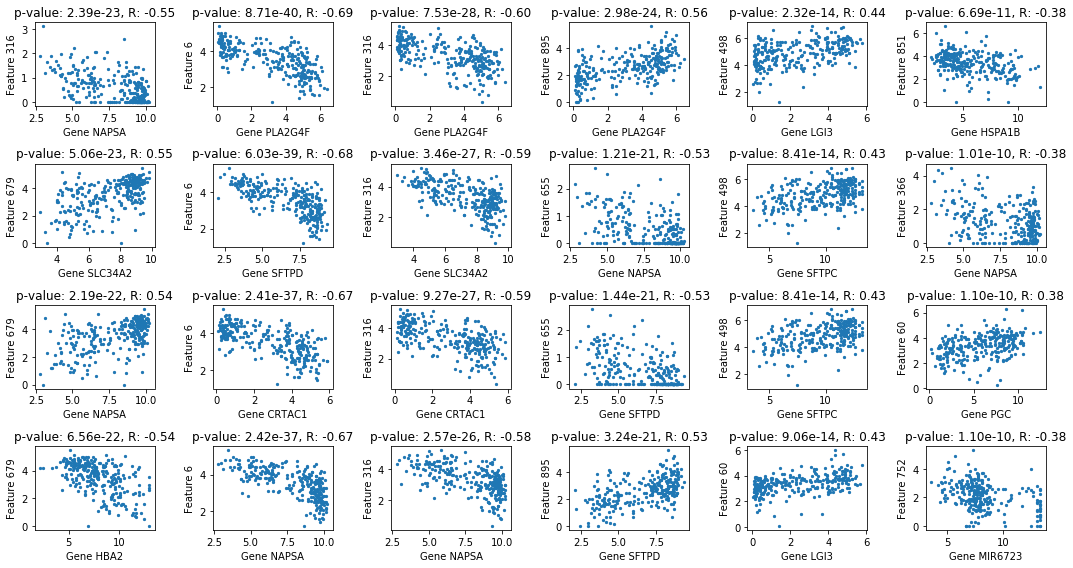

In [66]:
fig, ax = plt.subplots(4,6,figsize=(15,8))
aggregation = 'mean'
for (s,size) in enumerate(['128','256','512','1024','2048','4096']):
    pvalues = results['{}_{}_pvalues'.format(aggregation,size)]
    R_matrix = results['{}_{}_R'.format(aggregation,size)]
    N, M = pvalues.shape



    for k in range(4):
        value = np.sort(pvalues.flatten())[k]
        row, col = np.argwhere(pvalues == value)[0]

    #     print ('pvalue: {:0.2e}'.format(pvalues[row,col]))
    #     print ('R: {:0.2f}'.format(R_matrix[row,col]))

        f = filt_mean_features[str(size)][:,row]
        t = filt_expression[:,col]
        ax[k][s].set_title('p-value: {:0.2e}, R: {:0.2f}'.format(pvalues[row,col], R_matrix[row,col]))
        expressionID = expression_IDs[most_expressed_transcript_idx][col].decode('utf8').split('.')[0]
        geneID = data.gene_by_id(expressionID).gene_name
        ax[k][s].set_xlabel('Gene {}'.format(geneID))
        ax[k][s].set_ylabel('Feature {}'.format(np.array(range(size_mean_features.shape[1]))[most_varying_feature_idx][row]))
        ax[k][s].scatter(t,f,s=5)
    fig.tight_layout()

In [7]:
import pandas as pd
df = pickle.load(open(GTEx_directory + '/data/phenotype_pandas_dataframe.py','rb'))

lung_df = df[df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]

SMTSISCH = np.log(np.array(lung_df['SMTSISCH']).astype(np.float32))
SMTSISCH = SMTSISCH[phenotype_idx]
SMRIN = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMRIN']) ])
SMRIN = SMRIN[phenotype_idx]
SMEXNCRT = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMEXNCRT']) ])
SMEXNCRT = SMEXNCRT[phenotype_idx]
SMNTRNRT = np.array([float(x) if x != '' else 0 for x in np.array(lung_df['SMNTRNRT']) ])
SMNTRNRT = SMNTRNRT[phenotype_idx]

In [10]:
ax.shape

(10, 5)

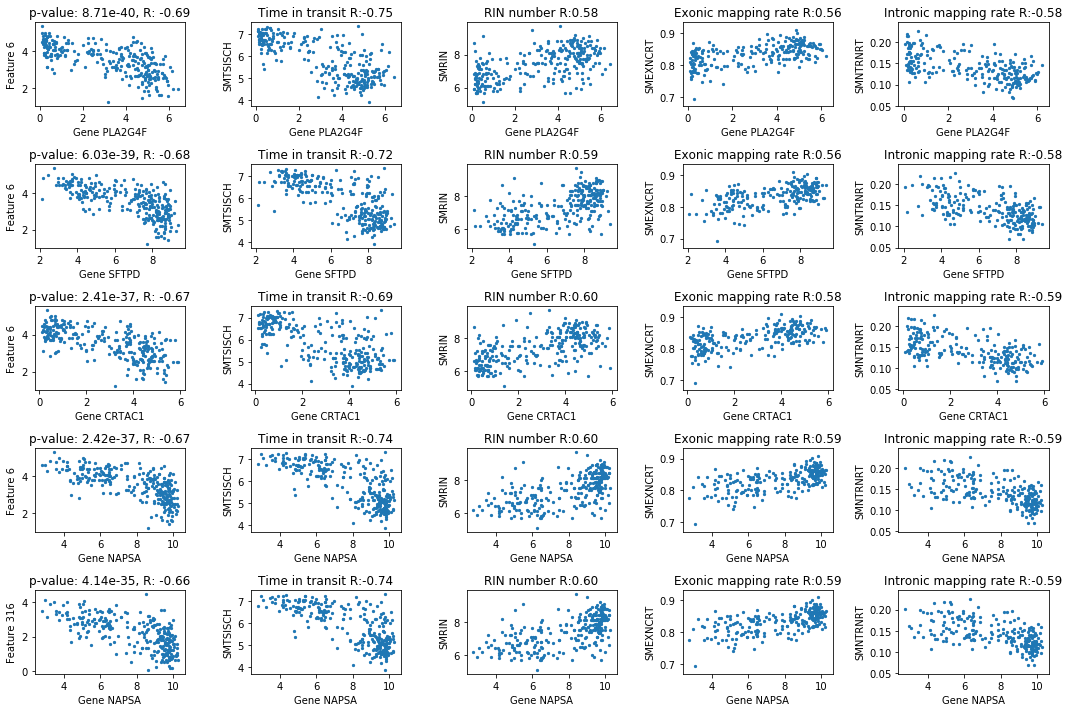

In [33]:
size = '256'
N = 5
fig, ax = plt.subplots(N,5,figsize=(15,10))
# fig.suptitle("Top 5 associated transcripts + relationship to technical factors",size=15)
aggregation = 'mean'
pvalues = results['{}_{}_pvalues'.format(aggregation,size)]
R_matrix = results['{}_{}_R'.format(aggregation,size)]

from pyensembl import EnsemblRelease
data = EnsemblRelease(77)



for k in range(N):
    value = np.sort(pvalues.flatten())[k]
    row, col = np.argwhere(pvalues == value)[0]

    f = filt_mean_features[str(size)][:,row]
    t = filt_expression[:,col]

    expressionID = expression_IDs[most_expressed_transcript_idx][col].decode('utf8').split('.')[0]
    geneID = data.gene_by_id(expressionID).gene_name
    
    
    ax[k][0].set_title('p-value: {:0.2e}, R: {:0.2f}'.format(pvalues[row,col], R_matrix[row,col]))
    ax[k][0].set_xlabel('Gene {}'.format(geneID))
    ax[k][0].set_ylabel('Feature {}'.format(np.array(range(size_mean_features.shape[1]))[most_varying_feature_idx][row]))
    ax[k][0].scatter(t,f,s=5)

    ax[k][1].scatter(t[SMTSISCH > 0],SMTSISCH[SMTSISCH > 0],s=5)
    ax[k][1].set_ylabel("SMTSISCH")
    ax[k][1].set_title("Time in transit R:{:0.2f}".format(pearsonr(t[SMTSISCH > 0],SMTSISCH[SMTSISCH > 0])[0]))
    ax[k][1].set_xlabel('Gene {}'.format(geneID))
    

    ax[k][2].scatter(t[SMRIN > 0],SMRIN[SMRIN > 0],s=5)
    ax[k][2].set_title("RIN number R:{:0.2f}".format(pearsonr(t[SMRIN > 0],SMRIN[SMRIN > 0])[0]))
    ax[k][2].set_ylabel("SMRIN")
    ax[k][2].set_xlabel('Gene {}'.format(geneID))

    ax[k][3].scatter(t[SMEXNCRT > 0],SMEXNCRT[SMEXNCRT > 0],s=5)
    ax[k][3].set_title("Exonic mapping rate R:{:0.2f}".format(pearsonr(t[SMEXNCRT > 0],SMEXNCRT[SMEXNCRT > 0])[0]))
    ax[k][3].set_ylabel("SMEXNCRT")
    ax[k][3].set_xlabel('Gene {}'.format(geneID))

    ax[k][4].scatter(t[SMNTRNRT > 0],SMNTRNRT[SMNTRNRT > 0],s=5)
    ax[k][4].set_title("Intronic mapping rate R:{:0.2f}".format(pearsonr(t[SMNTRNRT > 0],SMNTRNRT[SMNTRNRT > 0])[0]))
    ax[k][4].set_ylabel("SMNTRNRT")
    ax[k][4].set_xlabel('Gene {}'.format(geneID))

    
plt.tight_layout()


In [30]:
pearsonr(SMEXNCRT,t)

(-0.016503299387588748, 0.78566210989312057)